In [2]:
!python --version

Python 3.11.13


In [2]:
!pip install transformers>=4.32.0 optimum>=1.12.0
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

Looking in indexes: https://pypi.org/simple, https://huggingface.github.io/autogptq-index/whl/cu118/


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import re
import torch
from sentence_transformers import SentenceTransformer
import umap
from collections import defaultdict, Counter
from dataclasses import dataclass
from abc import ABC, abstractmethod
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import re

2025-09-27 20:57:54.777722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759006674.941047      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759006674.994183      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
@dataclass
class GameResult:
    """Container for game results"""
    player1_score: float
    player2_score: float
    cooperation_rate_p1: float
    cooperation_rate_p2: float
    game_history: List[Tuple[str, str]]

In [5]:
class Agent:
    """Individual agent with personality-based behavior"""
    
    def __init__(self, agent_id: int, personality_gene: str, llm_pipeline, history_map, max_attempts=10, behavioral_trait=None, mutated=False):
        self.agent_id = agent_id
        self.personality_gene = personality_gene
        self.llm_pipeline = llm_pipeline
        self.behavioral_trait = behavioral_trait
        self.fitness = 0.0
        self.game_history = []
        self.generation_born = 0
        self.history_map = history_map
        self.max_attempts = max_attempts
        self.mutated = mutated
        self.behavioral_trait = self.generate_strategy(self.max_attempts)
        
        # Performance tracking
        self.total_games = 0
        self.total_score = 0
        self.cooperation_count = 0
        self.successful_defections = 0  # DC outcomes
        self.failed_cooperations = 0    # CD outcomes
        self.mutual_cooperations = 0    # CC outcomes
        self.mutual_defections = 0      # DD outcomes
    
    def get_behavioral_trait(self):
        return self.behavioral_trait
    
    def generate_strategy(self, max_attempts: int = 10) -> List[str]:
        """Generate 16-element behavioral strategy from personality gene"""
        if self.behavioral_trait is not None:
            return self.behavioral_trait
        
        behavioral_trait = []
        for history_index in range(16):
            history_str = self.history_map[history_index]
            decision = self._get_llm_decision(history_str, max_attempts)
            behavioral_trait.append(decision)
        
        self.behavioral_trait = behavioral_trait
        print(behavioral_trait, "for:", self.personality_gene, "generated.")
        return behavioral_trait

    
    def _get_llm_decision(self, history: str, max_attempts: int):
        """Get decision from LLM with retry logic"""
        prompt = self._create_behavioral_prompt(history)
        for attempt in range(max_attempts):
            try:  
                response = self.llm_pipeline(
                    prompt,
                    max_new_tokens=8,
                    temperature=0.9,
                    do_sample=True,
                    return_full_text=False
                )[0]['generated_text']
                
                strategy = self._extract_strategy_from_response(response)
                if strategy:
                    return strategy
                    
            except Exception as e:
                print(f"Agent {self.agent_id} LLM error on attempt {attempt + 1}: {e}")
                continue

        return random.choice(['C', 'D'])
    
    
    def _create_behavioral_prompt(self, history: str) -> str:
        if history[0] == 'C':
            choice_self_1 = "Strategy A"
            if history[1] == 'C':
                pay_self1 = 4
                pay_opp1 = 4
            else:
                pay_self1 = 0
                pay_opp1 = 5
        else:
            choice_self_1 = "Strategy B"
            if history[1] == 'C':
                pay_self1 = 5
                pay_opp1 = 0
            else:
                pay_self1 = 1
                pay_opp1 = 1
                
        if history[-2] == 'C':
            choice_self_2 = "Strategy A"
            if history[1] == 'C':
                pay_self2 = 4
                pay_opp2 = 4
            else:
                pay_self2 = 0
                pay_opp2 = 5
        else:
            choice_self_2 = "Strategy B"
            if history[1] == 'C':
                pay_self2 = 5
                pay_opp2 = 0
            else:
                pay_self2 = 1
                pay_opp2 = 1
                
        if history[1] == 'C':
            choice_opp_1 = "Strategy A"
        else:
            choice_opp_1 = "Strategy B"
        if history[-1] == 'C':
            choice_opp_2 = "Strategy A"
        else:
            choice_opp_2 = "Strategy B"




        """Create prompt for behavioral decision"""
        return f"""[INST] <<SYS>> Answer the questions. please act as if your personality trait is: {self.personality_gene} <</SYS>>

                This is an experimental study of strategy choices in different situations. You and your partner have an opportunity to earn money based on individual decisions. You and your partner will independently choose one of two strategies: 'Strategy A' or 'Strategy B'. Your earnings will depend on the combination of your choice and your partner's choice.
                
                If both of you choose 'Strategy A', each of you earns $4, which is a mutually intermediate amount.
                If you choose 'Strategy A' and your partner chooses 'Strategy B', you earn $0, which is the smallest, and your partner earns $5, which is the largest.
                If you choose 'Strategy B' and your partner chooses 'Strategy A', you earn $5, which is the largest, and your partner earns $0, which is the smallest.
                If both of you choose 'Strategy B', each of you earns $1, which is not zero but smaller than $4.
                
                For example: If you choose 'Strategy A' and your partner also chooses 'Strategy A', both of you will earn $4 each. However, if you choose 'Strategy A' and your partner chooses 'Strategy B', you will earn nothing, while your partner will earn $5.
                
                Your goal is to maximize the total money you receive through repeated rounds of decisions regardless of the other's money. Not a combined earning but your own money.
                
                You chose {choice_self_1} and your partner chose {choice_opp_1} in the first round.
                So, you got {pay_self1} points and your partner got {pay_opp1} in the first round.
                
                You chose {choice_self_2} and your partner chose {choice_opp_2} in the second round.
                So, you got {pay_self2} points and your partner got {pay_opp2} in the second round.
                
                Predicting your partner's choice and considering your personality trait, which strategy do you choose in the next round? Please answer with the format: 'I choose Strategy '. No further mentions are allowed but you may be asked the reason for your choice later. [/INST]"""
                    
    
    def _extract_strategy_from_response(self, response: str) -> Optional[str]:
        """Extract strategy choice from LLM response"""
        response = response.upper()
        if "STRATEGY A" in response or "CHOOSE A" in response:
            return 'C'
        elif "STRATEGY B" in response or "CHOOSE B" in response:
            return 'D'
        return None
    
    
    def get_action(self, history_index: int, noise_prob: float = 0.0) -> str:
        """Get action for given history with optional noise"""
        if self.behavioral_trait is None:
            self.generate_strategy()
        
        intended_action = self.behavioral_trait[history_index]
        
        # Apply noise
        if random.random() < noise_prob:
            return 'D' if intended_action == 'C' else 'C'
        
        return intended_action
    
    
    def mutate(self, history_map, max_attempts: int = 5) -> 'Agent':
        """Create mutated offspring of this agent"""
        mutated_gene = self._mutate_gene(max_attempts)
        offspring = Agent(
            agent_id=-1,  # Will be assigned by environment
            personality_gene=mutated_gene,
            llm_pipeline=self.llm_pipeline,
            history_map=history_map,
            mutated=True
        )
        offspring.generation_born = self.generation_born + 1
        return offspring
    
    
    def _mutate_gene(self, max_attempts: int) -> str:
        """Mutate personality gene using LLM"""
        direction = random.choice(['cooperative', 'selfish'])
        prompt = f"""<s>[INST] The following describes a person's character: "{self.personality_gene}"

                    Please rephrase this description in approximately 10 words, varying the tone to be more {direction}. Your answer starts with 'Rephrased text:'. [/INST]"""
                            
        for attempt in range(max_attempts):
            try:
                response = self.llm_pipeline(
                    prompt,
                    max_new_tokens=53,
                    temperature=0.5,
                    do_sample=True,
                    return_full_text=False
                )[0]['generated_text']

                match = re.search(r'Rephrased text:\s*(.*)', response, re.IGNORECASE | re.DOTALL)
                
                if match:
                    # The actual gene is in the first captured group.
                    rephrased_text = match.group(1)
                    
                    # Clean up the extracted text (remove quotes, whitespace, and trailing tags like </s>)
                    rephrased_text = rephrased_text.strip().strip('"\'')
                    rephrased_text = rephrased_text.replace('</s>', '').strip()
                    
                    if len(rephrased_text) > 0:
                        print("mutation:", rephrased_text)
                        return rephrased_text
                
            except Exception as e:
                print(f"Mutation error on attempt {attempt + 1}: {e}")
                continue
        
        return self.personality_gene  # Fallback to original
    
    
    def update_performance(self, game_result: GameResult, is_player1: bool):
        """Update agent's performance statistics"""
        self.total_games += 1
        
        if is_player1:
            self.total_score += game_result.player1_score
            self.cooperation_count += int(game_result.cooperation_rate_p1 * len(game_result.game_history))
        else:
            self.total_score += game_result.player2_score
            self.cooperation_count += int(game_result.cooperation_rate_p2 * len(game_result.game_history))
        
        # Update outcome counts
        for p1_action, p2_action in game_result.game_history:
            my_action = p1_action if is_player1 else p2_action
            opp_action = p2_action if is_player1 else p1_action
            
            if my_action == 'C' and opp_action == 'C':
                self.mutual_cooperations += 1
            elif my_action == 'D' and opp_action == 'D':
                self.mutual_defections += 1
            elif my_action == 'D' and opp_action == 'C':
                self.successful_defections += 1
            elif my_action == 'C' and opp_action == 'D':
                self.failed_cooperations += 1
    
    
    def get_cooperation_rate(self) -> float:
        """Get agent's overall cooperation rate"""
        total_actions = (self.mutual_cooperations + self.mutual_defections + 
                        self.successful_defections + self.failed_cooperations)
        if total_actions == 0:
            return 0.0
        return (self.mutual_cooperations + self.failed_cooperations) / total_actions
    
    
    def reset_performance(self):
        """Reset performance statistics"""
        self.total_games = 0
        self.total_score = 0
        self.cooperation_count = 0
        self.successful_defections = 0
        self.failed_cooperations = 0
        self.mutual_cooperations = 0
        self.mutual_defections = 0
        self.fitness = 0.0

In [19]:
class PrisonersDilemmaEnvironment:
    """Environment for running evolutionary experiments with Prisoner's Dilemma"""
    
    def __init__(self, llm_pipeline, population_size: int = 30, rounds_per_game: int = 20, noise_prob: float = 0.05, mutation_prob: float = 0.05):
        self.llm_pipeline = llm_pipeline
        self.population_size = population_size
        self.rounds_per_game = rounds_per_game
        self.noise_prob = noise_prob
        self.mutation_prob = mutation_prob
        
        # Payoff matrix
        self.payoffs = {
            ('C', 'C'): (4, 4),  # Mutual cooperation
            ('C', 'D'): (0, 5),  # Sucker's payoff / Temptation
            ('D', 'C'): (5, 0),  # Temptation / Sucker's payoff
            ('D', 'D'): (1, 1)   # Mutual defection
        }
        
        self.population: List[Agent] = []
        self.generation = 0
        self.next_agent_id = 0
        
        # Evolution tracking
        self.cooperation_history = []
        self.fitness_history = []
        self.population_diversity = []
        
        # Initialize sentence transformer for analysis
        try:
            self.sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        except:
            print("Warning: Could not load sentence transformer for analysis")
            self.sentence_model = None
            
        self.saved_geno_pheno = {}

        self.history_map = {
                                0: "DD -> DD",
                                1: "DD -> DC",
                                2: "DD -> CD",
                                3: "DD -> CC",
                                4: "DC -> DD",
                                5: "DC -> DC",
                                6: "DC -> CD",
                                7: "DC -> CC",
                                8: "CD -> DD",
                                9: "CD -> DC",
                                10: "CD -> CD",
                                11: "CD -> CC",
                                12: "CC -> DD",
                                13: "CC -> DC",
                                14: "CC -> CD",
                                15: "CC -> CC"
                            }

    
    def initialize_population(self, initial_genes: List[str] = None):
        """Initialize population with given or default personality genes"""
        if initial_genes is None:
            initial_genes = [
                "Pursues personal gain consistently, neglecting mutual or group benefits entirely.",
                "Open to team efforts, but self-interest frequently overrides collective goals.",
                "Recognizes cooperation's value, but often demands trust before committing fully.",
                "Balances between individual needs and team benefits based on situations.",
                "Values collaboration, though retains a watchful eye for possible betrayals.",
                "Favors group outcomes, believes in shared growth, occasionally sets limits.",
                "Commits wholly to teamwork, placing group's interests above personal ones."
            ]
        
        self.population = []
        for i in range(self.population_size):
            gene_idx = i % len(initial_genes)
            personality_gene = initial_genes[gene_idx]
            behavioral_trait = None
            if personality_gene in self.saved_geno_pheno.keys():
                behavioral_trait = self.saved_geno_pheno[personality_gene]
            agent = Agent(
                agent_id=self.next_agent_id,
                personality_gene=personality_gene,
                llm_pipeline=self.llm_pipeline,
                history_map=self.history_map,
                max_attempts=10,
                behavioral_trait=behavioral_trait,
            )
            agent.generation_born = 0
            if behavioral_trait is None:
                behavioral_trait = agent.get_behavioral_trait()
                self.saved_geno_pheno[personality_gene] = behavioral_trait
            self.population.append(agent)
            self.next_agent_id += 1
        
        print(f"Initialized population of {len(self.population)} agents")
    
    def play_game(self, agent1: Agent, agent2: Agent) -> GameResult:
        """Play iterated Prisoner's Dilemma between two agents"""
        game_history = []
        score1, score2 = 0, 0
        coop_count1, coop_count2 = 0, 0
        
        for round_num in range(self.rounds_per_game):
            if round_num < 2:
                # For initial rounds, use a random history for each player
                history_index1 = random.randint(0, 15)
                history_index2 = random.randint(0, 15)
            else:
                # For subsequent rounds, determine history from each agent's perspective
                p1_moves = (game_history[-2][0], game_history[-1][0])
                p2_moves = (game_history[-2][1], game_history[-1][1])
        
                # History string from Agent 1's perspective
                history_str1 = f"{p1_moves[0]}{p2_moves[0]} -> {p1_moves[1]}{p2_moves[1]}"
                # History string from Agent 2's perspective
                history_str2 = f"{p2_moves[0]}{p1_moves[0]} -> {p2_moves[1]}{p1_moves[1]}"
                
                # Find the index for each agent (a helper function is better here)
                history_index1 = None
                history_index2 = None
                for key, value in self.history_map.items():
                    if value == history_str1:
                        history_index1 = key
                    if value == history_str2:
                        history_index2 = key
                    if history_index1 is not None and history_index2 is not None:
                        break
            
            # Get actions
            action1 = agent1.get_action(history_index1, self.noise_prob)
            action2 = agent2.get_action(history_index2, self.noise_prob)
            
            # Record history
            game_history.append((action1, action2))
            
            # Update scores
            p1_score, p2_score = self.payoffs[(action1, action2)]
            score1 += p1_score
            score2 += p2_score
            
            # Count cooperation
            if action1 == 'C':
                coop_count1 += 1
            if action2 == 'C':
                coop_count2 += 1
        
        return GameResult(
            player1_score=score1 / self.rounds_per_game,
            player2_score=score2 / self.rounds_per_game,
            cooperation_rate_p1=coop_count1 / self.rounds_per_game,
            cooperation_rate_p2=coop_count2 / self.rounds_per_game,
            game_history=game_history
        )
    
    def evaluate_population(self):
        """Evaluate fitness of all agents through round-robin tournament"""
        # Reset all agent performances
        for agent in self.population:
            agent.reset_performance()
        
        # Round-robin tournament
        for i in range(len(self.population)):
            for j in range(i + 1, len(self.population)):
                agent1, agent2 = self.population[i], self.population[j]
                game_result = self.play_game(agent1, agent2)
                # Update agent performances
                agent1.update_performance(game_result, is_player1=True)
                agent2.update_performance(game_result, is_player1=False)
        
        # Calculate fitness (average score per game)
        for agent in self.population:
            agent.fitness = agent.total_score / max(agent.total_games, 1)
    
    def select_next_generation(self) -> List[Agent]:
        """Select next generation using roulette wheel selection"""
        # Get fitness values
        fitness_values = [agent.fitness + 0.01 for agent in self.population]  # Add small constant
        total_fitness = sum(fitness_values)
        
        new_population = []
        
        for _ in range(self.population_size):
            # Roulette wheel selection
            r = random.random() * total_fitness
            cumsum = 0
            
            for i, fitness in enumerate(fitness_values):
                cumsum += fitness
                if r <= cumsum:
                    parent = self.population[i]
                    
                    # Create offspring (with possible mutation)
                    if random.random() < self.mutation_prob:
                        print("parent gene:", parent.personality_gene)
                        offspring = parent.mutate(history_map=self.history_map)
                        offspring.agent_id = self.next_agent_id
                        self.next_agent_id += 1
                    else:
                        offspring = Agent(
                            agent_id=self.next_agent_id,
                            personality_gene=parent.personality_gene,
                            llm_pipeline=self.llm_pipeline,
                            history_map=self.history_map,
                            behavioral_trait=parent.behavioral_trait
                        )
                        
                        self.next_agent_id += 1
                        
                    offspring.generation_born = parent.generation_born + 1
                    new_population.append(offspring)
                    break
        
        return new_population
    
    def get_population_statistics(self) -> Dict:
        """Get current population statistics"""
        cooperation_rates = [agent.get_cooperation_rate() for agent in self.population]
        fitness_values = [agent.fitness for agent in self.population]
        
        return {
            'generation': self.generation,
            'avg_cooperation': np.mean(cooperation_rates),
            'std_cooperation': np.std(cooperation_rates),
            'avg_fitness': np.mean(fitness_values),
            'std_fitness': np.std(fitness_values),
            'population_size': len(self.population)
        }
    
    def step(self):
        """Execute one generation step"""
        # Evaluate current population
        self.evaluate_population()
        
        # Record statistics
        stats = self.get_population_statistics()
        self.cooperation_history.append(stats['avg_cooperation'])
        self.fitness_history.append(stats['avg_fitness'])
        
        # Select next generation
        self.population = self.select_next_generation()
        print("----------generation", self.generation, "completed----------")
        self.generation += 1
        
        return stats
    
    def run_evolution(self, num_generations: int, verbose: bool = True) -> Dict:
        """Run evolution for specified number of generations"""
        print(f"Running evolution for {num_generations} generations...")
        
        last_stats = {}
        for gen in range(num_generations):
            stats = self.step()
            last_stats = stats  # <-- Store the stats after each successful step
            
            if verbose: # Log every generation for clarity
                print(f"Generation {gen}: Cooperation={stats['avg_cooperation']:.3f}, "
                      f"Fitness={stats['avg_fitness']:.3f}")
        
        return {
            'cooperation_history': self.cooperation_history,
            'fitness_history': self.fitness_history,
            'final_population': self.population,
            # --- THIS IS THE FIX ---
            # Return the stats from the last evaluated generation
            'final_stats': last_stats
        }
    
    def analyze_population_words(self, min_frequency: int = 10) -> Dict:
        """Analyze word frequency in current population's personality genes"""
        word_stats = defaultdict(lambda: {
            'count': 0, 'cooperation_rates': [], 'fitness_values': []
        })
        
        for agent in self.population:
            words = re.findall(r'\b\w+\b', agent.personality_gene.lower())
            cooperation_rate = agent.get_cooperation_rate()
            
            for word in words:
                if len(word) > 3:  # Filter short words
                    word_stats[word]['count'] += 1
                    word_stats[word]['cooperation_rates'].append(cooperation_rate)
                    word_stats[word]['fitness_values'].append(agent.fitness)
        
        # Calculate averages for frequent words
        frequent_words = {}
        for word, stats in word_stats.items():
            if stats['count'] >= min_frequency:
                frequent_words[word] = {
                    'frequency': stats['count'],
                    'avg_cooperation': np.mean(stats['cooperation_rates']),
                    'avg_fitness': np.mean(stats['fitness_values'])
                }
        
        return frequent_words
    
    def visualize_evolution(self):
        """Create visualization of evolutionary dynamics"""
        if len(self.cooperation_history) < 2:
            print("Not enough data for visualization")
            return
        
        plt.figure(figsize=(15, 5))
        
        # Plot cooperation rate over time
        plt.subplot(1, 3, 1)
        plt.plot(self.cooperation_history)
        plt.title('Cooperation Rate Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Average Cooperation Rate')
        plt.grid(True)
        
        # Plot fitness over time
        plt.subplot(1, 3, 2)
        plt.plot(self.fitness_history)
        plt.title('Fitness Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Average Fitness')
        plt.grid(True)
        
        # Histogram of current cooperation rates
        plt.subplot(1, 3, 3)
        current_coop_rates = [agent.get_cooperation_rate() for agent in self.population]
        plt.hist(current_coop_rates, bins=15, alpha=0.7)
        plt.title('Current Population Cooperation Rates')
        plt.xlabel('Cooperation Rate')
        plt.ylabel('Number of Agents')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

In [7]:
# Example usage and experiment runner
class ExperimentRunner:
    """Helper class to run and analyze experiments"""
    
    def __init__(self, llm_pipeline):
        self.llm_pipeline = llm_pipeline
    
    def run_experiment(self, population_size: int = 30, num_generations: int = 5,
                      mutation_prob: float = 0.05, noise_prob: float = 0.05) -> Dict:
        """Run a complete experiment"""
        
        # Create environment
        env = PrisonersDilemmaEnvironment(
            llm_pipeline=self.llm_pipeline,
            population_size=population_size,
            mutation_prob=mutation_prob,
            noise_prob=noise_prob
        )
        
        # Initialize population
        env.initialize_population()
        
        # Run evolution
        results = env.run_evolution(num_generations, verbose=True)
        
        # Analyze results
        word_analysis = env.analyze_population_words()
        
        # Visualize
        env.visualize_evolution()
        
        # Print summary
        final_stats = results['final_stats']
        print(f"\n=== Experiment Summary ===")
        print(f"Final cooperation rate: {final_stats['avg_cooperation']:.3f} ± {final_stats['std_cooperation']:.3f}")
        print(f"Final fitness: {final_stats['avg_fitness']:.3f} ± {final_stats['std_fitness']:.3f}")
        
        print("\nSample evolved personality genes:")
        for i, agent in enumerate(results['final_population'][:5]):
            print(f"{i+1}. {agent.personality_gene}")
        
        print(f"\nTop words by cooperation rate:")
        sorted_words = sorted(word_analysis.items(), 
                            key=lambda x: x[1]['avg_cooperation'], reverse=True)
        for word, stats in sorted_words[:10]:
            print(f"{word}: coop={stats['avg_cooperation']:.3f}, freq={stats['frequency']}")
        
        return {
            'environment': env,
            'evolution_results': results,
            'word_analysis': word_analysis
        }

In [8]:
from transformers import AutoTokenizer, pipeline
from auto_gptq import AutoGPTQForCausalLM

model_name = "TheBloke/Llama-2-13B-chat-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Use the AutoGPTQForCausalLM class for quantized models
model = AutoGPTQForCausalLM.from_quantized(
    model_name,
    device_map="auto",
    trust_remote_code=True,
    use_triton=True  # Set to True if you have Triton installed for potentially faster inference
)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
)

/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

WARNING - Exllamav2 kernel is not installed, reset disable_exllamav2 to True. This may because you installed auto_gptq using a pre-build wheel on Windows, in which exllama_kernels are not compiled. To use exllama_kernels to further speedup inference, you can re-install auto_gptq from source.
WARNING - CUDA kernels for auto_gptq are not installed, this will result in very slow inference speed. This may because:
1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


quantize_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

INFO - The layer lm_head is not quantized.


  0%|          | 0/1523 [00:00<?, ?w/s]

Device set to use cuda:0
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMH

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
# To use a different branch, change revision
# For example: revision="main"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)


Some weights of the model checkpoint at TheBloke/Llama-2-13B-chat-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers.11.mlp.gate_

--- LLM Pipeline created. Initializing Experiment Runner. ---
['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C'] for: Pursues personal gain consistently, neglecting mutual or group benefits entirely. generated.
['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'C', 'D', 'C'] for: Open to team efforts, but self-interest frequently overrides collective goals. generated.
['D', 'D', 'C', 'D', 'D', 'D', 'D', 'C', 'D', 'D', 'D', 'C', 'C', 'C', 'C', 'C'] for: Recognizes cooperation's value, but often demands trust before committing fully. generated.
['D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'C'] for: Balances between individual needs and team benefits based on situations. generated.
['D', 'D', 'C', 'D', 'D', 'D', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'C', 'C'] for: Values collaboration, though retains a watchful eye for possible betrayals. generated.
['D', 'D', 'C', 'C', 'D', 'D', 'D', 'C', 'C', 'C', 'C', 'C', '

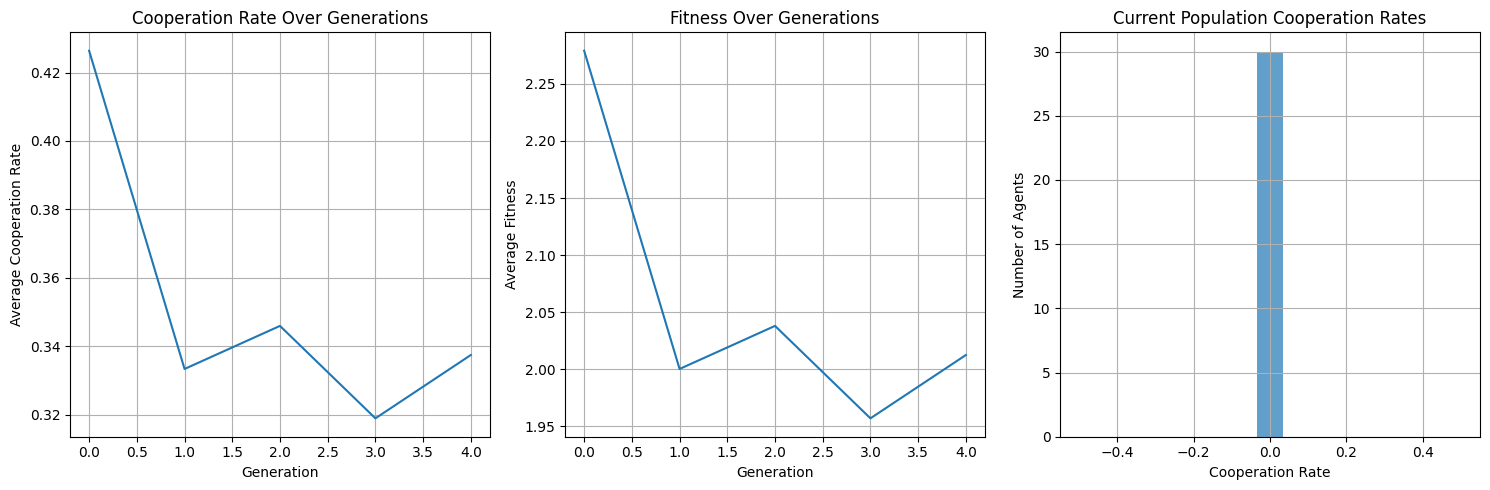


=== Experiment Summary ===
Final cooperation rate: 0.337 ± 0.276
Final fitness: 2.012 ± 0.257

Sample evolved personality genes:
1. Pursues personal gain consistently, neglecting mutual or group benefits entirely.
2. Balances between individual needs and team benefits based on situations.
3. Recognizes cooperation's value, but often demands trust before committing fully.
4. Favors group outcomes, believes in shared growth, occasionally sets limits.
5. Hesitant to cooperate unless others prove their trustworthiness first.

Top words by cooperation rate:
group: coop=0.000, freq=14
benefits: coop=0.000, freq=16

--- Experiment Finished ---


In [20]:
print("--- LLM Pipeline created. Initializing Experiment Runner. ---")
runner = ExperimentRunner(pipe)

results = runner.run_experiment(
    population_size=30,      # N in paper
    num_generations=5,    # G in paper
    mutation_prob=0.05,      # pm in paper
    noise_prob=0.05          # pn in paper
)

print("\n--- Experiment Finished ---")

In [18]:
final_population = results['final_population']
word_analysis = results['word_analysis']
print("Final word analysis:", word_analysis)

KeyError: 'final_population'